<a href="https://colab.research.google.com/github/simasaadi/Urban-Sustainability-Score-Drivers-Trade-offs-and-Scenario-Simulator/blob/main/02_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling — Urban Sustainability Score

This notebook builds baseline and tree-based regression models with cross-validation and reports performance metrics for predicting the Urban Sustainability Score.


In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42


In [ ]:
DATA_PATH = "/content/urban_planning_dataset.csv"

assert os.path.exists(DATA_PATH), f"File not found at: {DATA_PATH}. Upload it to Colab or move it into /content."
df = pd.read_csv(DATA_PATH)

print("Loaded ✅", df.shape)
df.head(3)


Loaded ✅ (3476, 16)


,building_density,road_connectivity,public_transport_access,air_quality_index,green_cover_percentage,carbon_footprint,population_density,crime_rate,avg_income,renewable_energy_usage,disaster_risk_index,land_use_type_Commercial,land_use_type_Green Space,land_use_type_Industrial,land_use_type_Residential,urban_sustainability_score
0,0.367915,0.393821,0.428129,0.414830,0.238555,0.921950,0.126449,0.547160,0.932412,0.382358,0.446242,0.0,0.0,1.0,0.0,0.259239
1,0.414306,0.608445,0.658481,0.490982,0.917681,0.178213,0.325124,0.764042,0.903241,0.377167,0.936824,0.0,1.0,0.0,0.0,0.576923
2,0.827902,0.444679,0.263853,0.264529,0.077883,0.295159,0.042150,0.575736,0.208098,0.237949,0.463054,0.0,0.0,0.0,1.0,0.252844


In [ ]:
TARGET = "urban_sustainability_score"
assert TARGET in df.columns, f"Missing target column: {TARGET}"

print("Missing cells total:", int(df.isna().sum().sum()))
print("Duplicate rows:", int(df.duplicated().sum()))

# Keep only numeric columns for modeling (dataset appears fully numeric)
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Confirm all features are numeric
non_numeric = X.columns[X.dtypes == "object"].tolist()
assert len(non_numeric) == 0, f"Non-numeric columns found: {non_numeric}"

print("X shape:", X.shape, "| y shape:", y.shape)


Missing cells total: 0
Duplicate rows: 0
X shape: (3476, 15) | y shape: (3476,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2780, 15) Test: (696, 15)


In [ ]:
def regression_report(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
    }


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)   # no squared=
    rmse = float(np.sqrt(mse))
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse,
        "R2": float(r2_score(y_true, y_pred)),
    }


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

ridge = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

ridge_results = regression_report(y_test, pred_ridge)
ridge_results


{'MAE': 5.020610138865819e-05,
 'RMSE': 6.237685202624059e-05,
 'R2': 0.9999998715493917}

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    random_state=RANDOM_STATE,
    max_depth=6,
    learning_rate=0.05,
    max_iter=400
)

hgb.fit(X_train, y_train)
pred_hgb = hgb.predict(X_test)

hgb_results = regression_report(y_test, pred_hgb)
hgb_results


{'MAE': 0.015406916956012887,
 'RMSE': 0.01947323692356289,
 'R2': 0.9874811177715064}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

ridge_cv = cross_validate(ridge, X, y, cv=cv, scoring=scoring)
hgb_cv = cross_validate(hgb, X, y, cv=cv, scoring=scoring)

def summarize_cv(cv_out):
    return {
        "MAE_mean": float(-np.mean(cv_out["test_mae"])),
        "RMSE_mean": float(-np.mean(cv_out["test_rmse"])),
        "R2_mean": float(np.mean(cv_out["test_r2"])),
    }

cv_summary = {
    "Ridge": summarize_cv(ridge_cv),
    "HistGB": summarize_cv(hgb_cv),
}

cv_summary


{'Ridge': {'MAE_mean': 4.8759988492855954e-05,
  'RMSE_mean': 5.978800103033796e-05,
  'R2_mean': 0.9999998752693667},
 'HistGB': {'MAE_mean': 0.014740132608591666,
  'RMSE_mean': 0.01861664640694546,
  'R2_mean': 0.9878844765788859}}

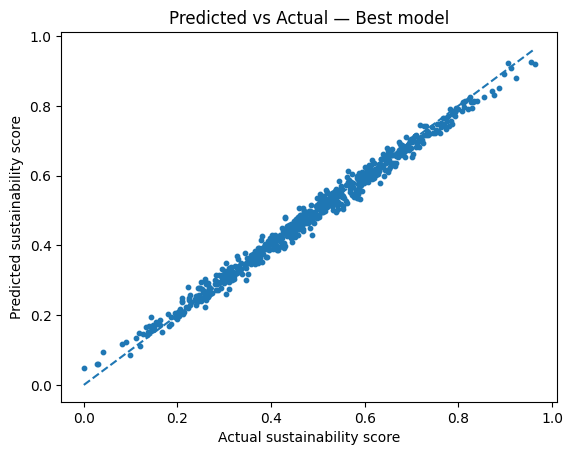

In [13]:
import matplotlib.pyplot as plt

y_pred = pred_hgb  # or whichever model performed best

plt.figure()
plt.scatter(y_test, y_pred, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("Actual sustainability score")
plt.ylabel("Predicted sustainability score")
plt.title("Predicted vs Actual — Best model")
plt.show()


In [14]:
import joblib

# Choose best by CV R2 (or lowest RMSE)
best_model = hgb

os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/best_model.joblib")

print("Saved ✅ models/best_model.joblib")


Saved ✅ models/best_model.joblib
